In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from os.path import join as pjoin
import json
print(os.getcwd())
sys.path.insert(0, pjoin(os.path.pardir))
sys.path.insert(0, pjoin(os.path.pardir, 'webapi'))
import numpy as np
import h5py
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from rttypes.volume import Volume
import dicomutils as du
import sparse
from planning.maskio import Mask
from skimage import measure

/home/ryan/projects/MCDose-electron/dosecalc/jupyter_notebooks


In [3]:
pdir = '/home/ryan/projects/MCDose-electron/test_noncoplanar/'
files = du.find_dicom_files(pjoin(pdir, 'ctdata'))
arr, vsize = du.extract_voxel_data(files['CT'])
vol = Volume.fromDir(pjoin(pdir, 'ctdata'))

doses = {}
fname = pjoin(pdir, 'sparsedose_new.h5') 
dose = sparse.SparseMatrixCOO.fromFile(pjoin(fname))
doses[fname] = np.array(dose.tocoo().todense())

In [4]:
masks = Mask.load_masks_from_file(pjoin(pdir, 'masks_new.h5'))

(174, 260, 260, 1379)


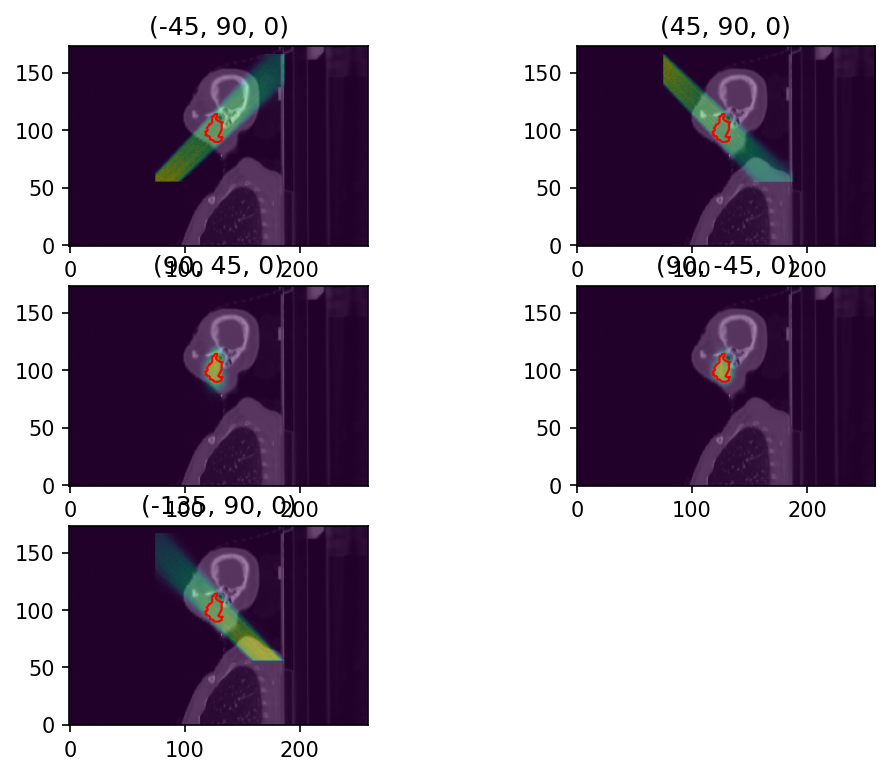

In [13]:
nbeamlets = [256, 270, 323, 261, 269]
angles = [
    (-45, 90, 0),
    (45,  90, 0),
    (90, 45, 0),
    (90, -45, 0),
    (-135, 90, 0)
]
fig = plt.figure(figsize=(8,6), dpi=150)
mark = 0
dose = doses[fname]
densedose = dose.reshape(*arr.shape, -1)
print(densedose.shape)
for ii, nbeamlets in enumerate(nbeamlets):
    dosename='{!s}'.format(angles[ii])

    sumdose = np.sum(densedose[:, :, :, mark:mark+nbeamlets], axis=3)

    #ptv_name = "PTV_NNreview"
    ptv_name = 'O_parotid_R'
    full_mask = masks[ptv_name].pad_to_original_size()
    idx = np.argmax(np.sum(full_mask, axis=(0,1)))
    contours = measure.find_contours(full_mask[:,:,idx], 0.9)
    
    ax = plt.subplot(3,2,ii+1)
    ax.imshow(arr[:, :, idx], origin='lower', cmap='gray')
    ax.imshow(sumdose[:, :, idx], origin='lower', alpha=0.5)
    #plt.imshow(masks[ptv_name].arr[idx], alpha=0.3)
    for contour in contours:
        ax.plot(contour[:,1], contour[:,0], color='red', linewidth=1)
    ax.set_title(dosename)
    mark += nbeamlets
plt.show()